In [1]:
VIDEO_DIR = '../../video/raw'
LABEL_DIR = 'data'

In [9]:
%%writefile vid_utils.py

import os
import sys

import numpy as np
import pandas as pd

import skvideo.io
from skimage.transform import resize

import matplotlib.pyplot as plt


class Video_Utils:
    
    def __init__(self, video_dir, label_dir):
        self.VIDEO_DIR = video_dir
        self.LABEL_DIR = label_dir
        self.vid_names = Video_Utils.get_possible_data(self.VIDEO_DIR, self.LABEL_DIR)
        
    def get_transformed_data(self, **kwargs):
        x,y = Video_Utils.load_all_data(self.vid_names)
        trans_x = Video_Utils.transform_data(x, **kwargs)
        print('transformed video now sized {}gb'.format(Video_Utils.vid_in_gbs(trans_x)))
        return trans_x, y
        
    
    @staticmethod
    def get_possible_data(vid_dir, label_dir):
        possible_vids = set(os.listdir(vid_dir))

        possible_labels = set(os.listdir(label_dir))

        usable_vids = []
        for vid in possible_vids:
            if (vid + '.csv') in possible_labels:
                usable_vids.append(vid)
                print('{} is good to use'.format(vid))
        return usable_vids
    
    @staticmethod
    def vid_in_gbs(vid):
        return sys.getsizeof(vid)/10**9

    
    @staticmethod
    def load_data(vid_name):

        vid_file_name = VIDEO_DIR + '/' + vid_name
        lab_file_name = LABEL_DIR + '/' + vid_name + '.csv'

        print('fetching ' + lab_file_name)
        lab_data = pd.read_csv(lab_file_name, sep=',').values[:,1:]

        vid_data = skvideo.io.vread(vid_file_name)

        print('loaded video sized {}gb'.format(Video_Utils.vid_in_gbs(vid_data)))


        assert(len(vid_data) == len(lab_data))

        return vid_data, lab_data
        
        
    @staticmethod
    def load_all_data(vid_names):

        all_vids = None
        all_labs = None

        for vid_name in vid_names:

            if all_vids is None:
                all_vids, all_labs = Video_Utils.load_data(vid_name)
            else:
                t_v, t_l = Video_Utils.load_data(vid_name)
                all_vids = np.concatenate(all_vids, t_v)
                all_labs = np.concatenate(all_labs, t_l)
                del t_v, t_l

        assert(len(all_vids) == len(all_labs))

        return all_vids, all_labs
            

    @staticmethod
    def rgb_to_gray(rgb):
        return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


    @staticmethod
    def resize_images(data, factor, verbose=True):
        # shrink 2nd and 3rd dimentions (height and width)     
        new_shape = [int(dim/factor) if (i in [1,2]) else dim 
                     for i, dim in enumerate(data.shape)]

        resized_images = np.zeros(new_shape)

        for i in range(len(data)):
            resized_images[i] = resize(data[i], 
                                       output_shape=new_shape[1:])
            if verbose and (i % 200) == 0:
                print('compressed {} images'.format(i))

        return resized_images

    
    @staticmethod
    def transform_data(data, 
                       crop_height=None, 
                       grayscale=True, 
                       resize_shrink_factor=5, 
                       sample=False,
                       verbose=True):

        output = data[:10] if sample else data

        if crop_height:
            if verbose:
                print('cropping...')
            curr_shape = output.shape
            output = output[:,crop_height[0]:crop_height[1]]

        if resize_shrink_factor != 1:
            if verbose:
                print('resizing...')
            output = Video_Utils.resize_images(output, resize_shrink_factor)

        if grayscale:
            if verbose:
                print('grayscaling..')
            output = Video_Utils.rgb_to_gray(output)  

        if verbose:
            print('done')

        return output
    
    @staticmethod
    def display_image_with_label(img, label):
        height, width = img.shape[0:2]
        plt.imshow(img)
        plt.axvline(label[0] * width, c='b')
        plt.axhline(label[1] * height, c='r')
        plt.show()

    @staticmethod   
    def show_sample_images_with_labels(images, labels, n=5):

        random_frame_indixes = np.random.randint(0, high=len(images), size=n)

        for index in random_frame_indixes:
            Video_Utils.display_image_with_label(images[index], labels[index])
    

Writing vid_utils.py


In [6]:
%matplotlib inline

In [3]:
vu = Video_Utils(VIDEO_DIR, LABEL_DIR)

VID_20180325_143338.mp4 is good to use


In [4]:
x, y = vu.get_transformed_data(crop_height=[150,350])

fetching data/VID_20180325_143338.mp4.csv
loaded video sized 1.384128144gb
cropping...
resizing...
compressed 0 images
compressed 200 images
compressed 400 images
compressed 600 images
compressed 800 images
compressed 1000 images
compressed 1200 images
grayscaling..
done
transformed video now sized 0.061516928gb


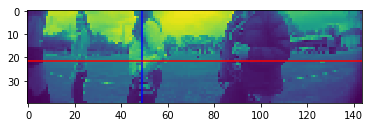

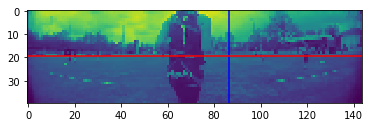

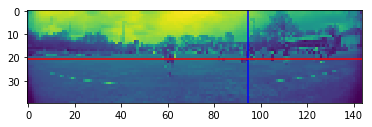

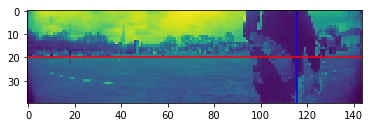

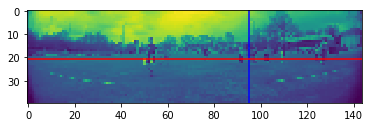

In [7]:
Video_Utils.show_sample_images_with_labels(x,y)

In [28]:
temp = (x[:-1] - x[1:])>0.01

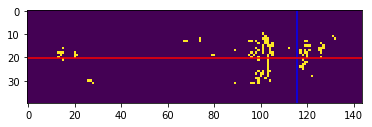

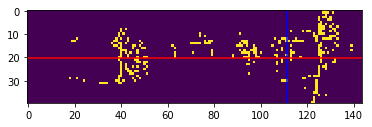

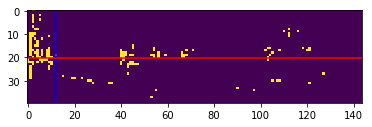

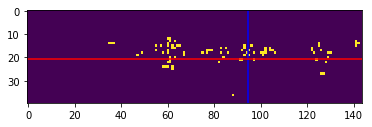

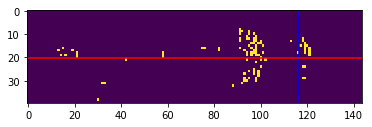

In [29]:
Video_Utils.show_sample_images_with_labels(temp,y)

In [22]:
x.max()

0.99999999999999989

In [23]:
x.min()

0.0